Based on [Hopfield Networks is All You Need](https://ml-jku.github.io/hopfield-layers/#hfnetworks) and [Week 08c: Hopfield Demonstration by Jeff Orchard](https://www.youtube.com/watch?v=81B-ESqgCjs)

In [1]:
import numpy as np, os, matplotlib.pyplot as plt
import copy
# set working dir to repo directory
head, tail = os.path.split(os.getcwd())
while tail != 'aj_python_tool_lib':
    head, tail = os.path.split(head)
os.chdir(os.path.join(head, tail))
os.getcwd()
from misc_tools.print_latex import print_tex

<IPython.core.display.Math object>

### Define patterns

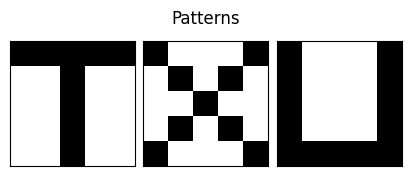

In [2]:
patterns = np.array([
    [
       [1,1,1,1,1],
       [0,0,1,0,0],
       [0,0,1,0,0],
       [0,0,1,0,0],
       [0,0,1,0,0]
        
    ],

    [
       [1,0,0,0,1],
       [0,1,0,1,0],
       [0,0,1,0,0],
       [0,1,0,1,0],
       [1,0,0,0,1]
        
    ],

    [
       [1,0,0,0,1],
       [1,0,0,0,1],
       [1,0,0,0,1],
       [1,0,0,0,1],
       [1,1,1,1,1]
        
    ],

])

N_mem = len(patterns)
len_state =patterns[0].size
mem_shape_OG = patterns[0].shape

fig, ax = plt.subplots(1,N_mem, figsize = (4,1.7), layout='constrained', sharex=True, sharey=True)
plt.suptitle('Patterns')


for a, pt in zip(ax, patterns):
   a.imshow(pt, 'gray_r')
   a.set_xticks([])
   a.set_yticks([])

### Flatten patterns (states) into 1D vector and remap to [-1,1] 
To be consistent with theory, lets represent states as column vectors:
1. Reshape flatten states so patterns shape = (N_mem, len_state) 
2. transpose shape = (len_state, N_mem) 

NOTE: its incorrect to reshape straight into (len_state, N_mem)  because all matrix will be flattened and just sliced <br>
NOTE: state flattening will be redistributed to different column vectors.

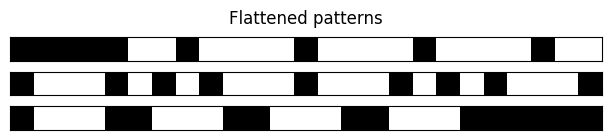

In [3]:
remap = lambda x: 2*x - 1   # [0,1]-> [0,2] -> [-1,1]
patterns = remap(patterns)

patterns = patterns.reshape(N_mem, len_state).T  # (-1,N_mem) fks internal ordering.

fig, ax = plt.subplots(N_mem,1, figsize = (6,1.3), layout='constrained', sharex=True, sharey=True)
plt.suptitle('Flattened patterns')

for a, pt in zip(ax, patterns.T):
   a.imshow([pt], 'gray_r')
   a.set_xticks([])
   a.set_yticks([])

### Bias:
NOTE: Parameter keepdims=True prevents from casting result in (N,) shape. It will cast into (N,1) or (1,N), depending on axis

In [4]:
b = np.average(patterns, axis=1, keepdims=True)
#print_tex('bias = ', b, column=False)
b.shape

(25, 1)

### Weights:
It can be shows that following expression

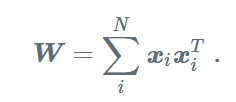

Is equivalent to $X X^T$ matrix multiplication

***
$X = \begin{bmatrix} 
        X_{1,1} & \ldots & X_{1,M}  \\ 
        \vdots  & \ddots & \vdots   \\ 
        X_{N,1} & \ldots & X_{N,M}
    \end{bmatrix} = 
        \begin{bmatrix} \vec{x}_1 & \ldots & \vec{x}_M\end{bmatrix} $

$\vec{x}_i = \begin{bmatrix} X_{1,i} \\ \vdots \\ X_{N,i} \end{bmatrix}; (i \in \{1,\ldots,M\}, \text{can assume } N \geq M)$


outer($\vec{x}_i, \vec{x}_i$) 
$=\vec{x}_i \bigotimes \vec{x}_i := \vec{x}_i \vec{x}^T_i= 
\begin{bmatrix} X_{1,i} \\ \vdots \\ X_{N,i} \end{bmatrix} \begin{bmatrix} X_{1,i} & \ldots  & X_{N,i} \end{bmatrix} = 
\begin{bmatrix} 
    X_{1,i} X_{1,i} & \ldots & X_{1,i} X_{N,i}  \\ 
    \vdots          & \ddots &    \vdots        \\
    X_{N,i} X_{1,i} & \ldots & X_{N,i} X_{N,i}  \\
\end{bmatrix} $
***

$W =\sum_{k=1}^M \vec{x}_k \vec{x}^T_k =
\sum_{k=1}^M
\begin{bmatrix} 
    X_{1,k} X_{1,k} & \ldots & X_{1,k} X_{N,k}  \\ 
    \vdots          & \ddots &  \vdots          \\
    X_{N,k} X_{1,k} & \ldots & X_{N,k} X_{N,k}  \\
\end{bmatrix} =
\begin{bmatrix} 
    \sum_{k=1}^M X_{1,k} X_{1,k}    & \ldots & \sum_{k=1}^M X_{1,k} X_{N,k}     \\ 
    \vdots                          & \ddots &   \vdots                         \\
    \sum_{k=1}^M X_{N,k} X_{1,k}    & \ldots & \sum_{k=1}^M X_{N,k} X_{N,k}     \\
\end{bmatrix} =
$

$
\begin{bmatrix} 
    X_{r,1} \cdot X_{r,1}  & \ldots & X_{r,1} \cdot X_{r,N}   \\ 
    \vdots                      & \ddots &       \vdots                 \\
    X_{r,N} \cdot X_{r,1}   & \ldots & X_{r,N} \cdot X_{r,N}    \\
\end{bmatrix} = 
\begin{bmatrix} 
    X_{r,1} \cdot X_{c,1}^T  & \ldots & X_{r,1} \cdot X_{c,N}^T   \\ 
    \vdots                      & \ddots &       \vdots                 \\
    X_{r,N} \cdot X_{c,1}^T   & \ldots & X_{r,N} \cdot X_{c,N}^T    \\
\end{bmatrix} = 
XX^T
$



(25, 3)


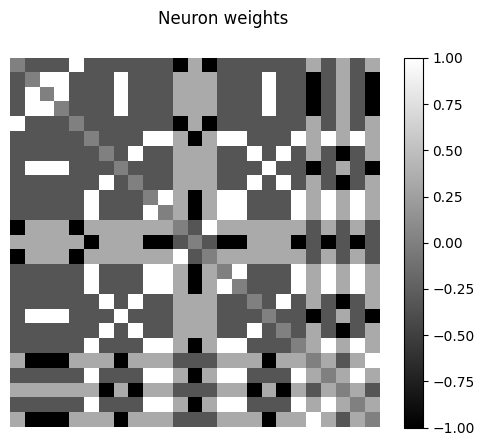

In [5]:
W = patterns @ patterns.T / N_mem - np.eye(len_state) 
print(patterns.shape)
#print_tex('W = ', W, column=False)
plt.imshow(W, 'gray')
plt.suptitle('Neuron weights')
plt.colorbar()
plt.axis('off');

### Hopfield energy:
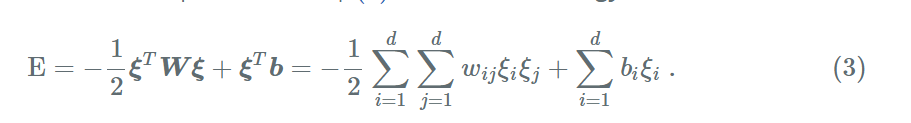

In [6]:
def state_energy(W, Xi, b):
    return -0.5 * Xi.T @ W @ Xi  + Xi.T @ b

def update_step(W,Xi,b):
        return np.sign(Xi @ W  - b).astype(int)

def Hamming_dist(x,y):
    return np.sum(x.flatten()!= y.flatten())

### Generate corrupted/perturbed state
Reverse entries in state vector based on mask generated using probabolistic approach.

NOTE: when picking columns of a matix using M[:,i] result is flattened into (N,) list.

NOTE: one way to keep column structure is to use M[: , i : i+1] or, simply, M[ : , [ i ] ]

In [7]:
np.random.seed(69)
target_state = 0
state_og = patterns[:,[target_state]]

perturb_prob = 0.3
mask_change = np.random.rand(*state_og.shape) < perturb_prob
mask_change = np.array(mask_change, int)    # once converted from bool cannot do a[mask], must do a[max==True] instead ?!
perturbed_state = copy.deepcopy(state_og)

perturbed_state[mask_change==True] *= -1

print_tex('og\_state \& mask \& new\_state =', np.hstack([state_og,mask_change,perturbed_state]).T, column=True)
print('Hamming_dist overlaps', Hamming_dist(state_og,perturbed_state)/len_state * 100, '% of total length')


<IPython.core.display.Math object>

Hamming_dist overlaps 36.0 % of total length


(25, 1)

Distances for all patrerns:
H-dist memory 0 -> new_state =  0
H-dist memory 1 -> new_state =  12
H-dist memory 2 -> new_state =  16


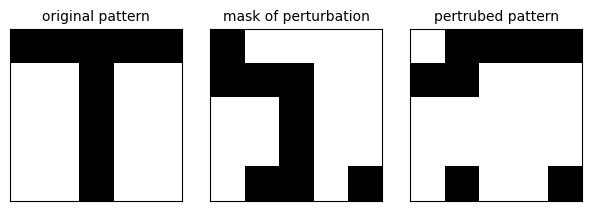

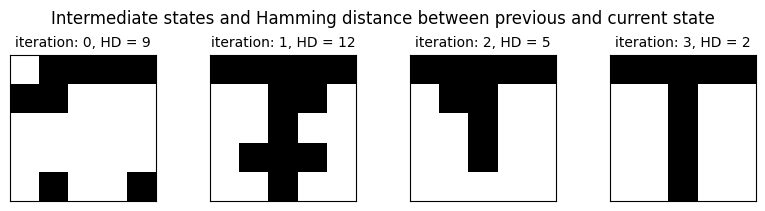

In [8]:
n_iters = 10
state = copy.deepcopy(perturbed_state)
print(state.shape)
intermediate_states = [perturbed_state]
intermediate_hamming_d = [Hamming_dist(state_og, perturbed_state)]
for i in range(n_iters):
    #state_new = update_step(W,state,b)
    state_new = np.sign(W @ state - b)
    dist = Hamming_dist(state, state_new)
    state = state_new
    if dist == 0: break
    intermediate_states.append(state)
    intermediate_hamming_d.append(dist)
    
print('\nDistances for all patrerns:')
for i,state in enumerate(patterns.T):
    print(f'H-dist memory {i} -> new_state = ', Hamming_dist(state, state_new))

fig, ax = plt.subplots(1,3, figsize = (2*N_mem,2), layout='constrained', sharex=True, sharey=True)
for a, st, lbl in zip(ax, [state_og,mask_change,perturbed_state],['original pattern', 'mask of perturbation', 'pertrubed pattern']):
   a.imshow(st.reshape(*mem_shape_OG), 'gray_r')
   a.set_title(lbl, fontsize=10)
   a.set_xticks([])
   a.set_yticks([])

n_i_st = len(intermediate_states)
fig, ax = plt.subplots(1,n_i_st, figsize = (2*n_i_st,2), layout='constrained', sharex=True, sharey=True)
plt.suptitle('Intermediate states and Hamming distance between previous and current state')
i = 0
for a, st, h_d in zip(ax, intermediate_states, intermediate_hamming_d):
   a.imshow(st.reshape(*mem_shape_OG), 'gray_r')
   a.set_title(f'iteration: {i}, HD = {h_d}', fontsize=10)
   a.set_xticks([])
   a.set_yticks([])
   i += 1